In [45]:
import numpy as np
import matplotlib.pyplot as plt
import dpdata
import glob
import seaborn as sns
import pandas as pd
import os

In [46]:
from __future__ import annotations

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from maml.sampling.direct import BirchClustering, DIRECTSampler, SelectKFromClusters

In [47]:
# load data
desc_string = 'descriptors/*/desc.npy'
dpdata_name = "FeCHO-clean-v2-7-20873"
dpdata_path = "./data-clean-v2-7-20873-npy"
dpdata_string = "O*"

In [48]:
# define used function
def extract_elements_array(data: dpdata.LabeledSystem) -> list:
    '''extract elements array from dpdata for draw t-SNE'''
    types = data.data['atom_types']
    names = data.data['atom_names']
    ele_array = [names[ind] for ind in types]
    return ele_array

# read descriptors/*/desc.npy data
print("Reading descriptor results...")
desc_keys = []
all_desc_stru = []
for f in glob.glob(desc_string):
    # extract dirname of desc.npy from descriptors/*
    directory, _ = os.path.split(f)
    _, keyname = os.path.split(directory)
    desc_keys.append(keyname)
    one_desc = np.load(f) # nframe, natoms, ndesc
    # do average in natoms dimension
    one_desc_stru = np.mean(one_desc, axis=1)
    all_desc_stru.append(one_desc_stru)
all_desc_stru = np.concatenate(all_desc_stru, axis=0)
np.shape(all_desc_stru)

Reading descriptor results...


(20873, 136)

In [49]:
# read dpdata for element type information 
#print("Reading corresponding dpdata...")
alldata =  dpdata.MultiSystems.from_dir(dpdata_path, dpdata_string, fmt="deepmd/npy")
alldata

MultiSystems (694 systems containing 20873 frames)

In [53]:
alldata_dict = {}
for lbsys in alldata:
    alldata_dict[lbsys.short_name] = lbsys

# get list of system name
sys_list = []
for keyname in desc_keys:
    target_sys = alldata_dict[keyname]
    for ind in range(target_sys.get_nframes()):
        sys_list.append(f"{keyname}-{ind}")
    
# get element ratio
element_ratio_dict = {}
element_names = alldata[0].get_atom_names()
for element in element_names:
    ratio_for_ele = []
    for keyname in desc_keys:
        target_sys = alldata_dict[keyname]
        ratio = target_sys.get_atom_numbs()[target_sys.get_atom_names().index(element)] / np.sum(target_sys.get_atom_numbs())
        ratio_for_ele.extend([ratio] * target_sys.get_nframes())
    element_ratio_dict[element] = ratio_for_ele

In [66]:
sys_list

['O0H0Fe24C12-0',
 'O0H0Fe24C12-1',
 'O0H0Fe24C12-2',
 'O0H0Fe24C12-3',
 'O0H0Fe24C12-4',
 'O0H0Fe24C12-5',
 'O0H0Fe24C12-6',
 'O0H0Fe24C12-7',
 'O0H0Fe24C12-8',
 'O0H0Fe24C12-9',
 'O0H0Fe24C12-10',
 'O0H0Fe24C12-11',
 'O0H0Fe24C12-12',
 'O0H0Fe24C12-13',
 'O0H0Fe24C12-14',
 'O0H0Fe24C12-15',
 'O0H0Fe24C12-16',
 'O0H0Fe24C12-17',
 'O0H0Fe24C12-18',
 'O0H0Fe24C12-19',
 'O0H3Fe33C2-0',
 'O0H3Fe33C2-1',
 'O0H3Fe33C2-2',
 'O0H3Fe33C2-3',
 'O0H3Fe33C2-4',
 'O0H3Fe33C2-5',
 'O0H3Fe33C2-6',
 'O0H3Fe33C2-7',
 'O0H3Fe33C2-8',
 'O0H3Fe33C2-9',
 'O0H3Fe33C2-10',
 'O0H3Fe33C2-11',
 'O0H3Fe33C2-12',
 'O0H3Fe33C2-13',
 'O0H3Fe33C2-14',
 'O0H3Fe33C2-15',
 'O0H3Fe33C2-16',
 'O0H3Fe33C2-17',
 'O0H3Fe33C2-18',
 'O0H3Fe33C2-19',
 'O0H3Fe33C2-20',
 'O0H3Fe33C2-21',
 'O0H3Fe33C2-22',
 'O0H3Fe33C2-23',
 'O0H3Fe33C2-24',
 'O0H3Fe33C2-25',
 'O0H3Fe33C2-26',
 'O0H3Fe33C2-27',
 'O0H3Fe33C2-28',
 'O0H3Fe33C2-29',
 'O0H2Fe28C14-0',
 'O0H2Fe28C14-1',
 'O0H2Fe28C14-2',
 'O0H2Fe28C14-3',
 'O0H2Fe28C14-4',
 'O0H2Fe28

In [54]:
%%time
DIRECT_sampler = DIRECTSampler(
    structure_encoder=None,
    clustering=BirchClustering(n=2000, threshold_init=0.05),
    select_k_from_clusters=SelectKFromClusters(k=1),
)

CPU times: user 308 μs, sys: 0 ns, total: 308 μs
Wall time: 313 μs


In [55]:
%%time
DIRECT_selection = DIRECT_sampler.fit_transform(all_desc_stru)

INFO:maml.sampling.pca:Selected first 16 PCs, explaining 91.26% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.05 and n=2000 gives 2000 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 2000 configurations.


CPU times: user 4.3 s, sys: 6.83 s, total: 11.1 s
Wall time: 3.15 s


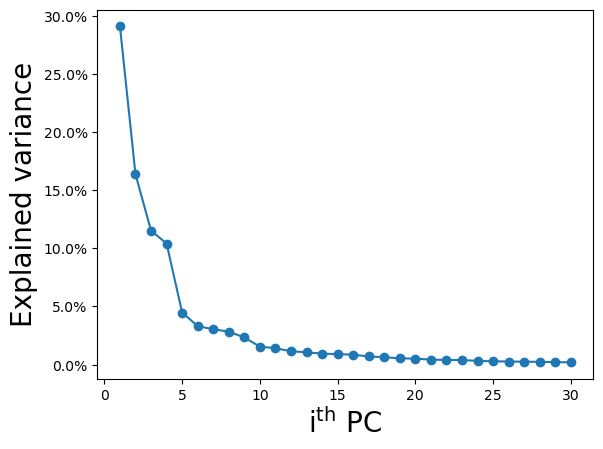

In [56]:
explained_variance = DIRECT_sampler.pca.pca.explained_variance_ratio_
DIRECT_selection["PCAfeatures_unweighted"] = DIRECT_selection["PCAfeatures"] / explained_variance[:16]

plt.plot(
    range(1, 31),
    explained_variance[:30] * 100,
    "o-",
)
plt.xlabel(r"i$^{\mathrm{th}}$ PC", size=20)
plt.ylabel("Explained variance", size=20)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [57]:
def plot_PCAfeature_coverage(all_features, selected_indexes, method="DIRECT"):
    fig, ax = plt.subplots(figsize=(5, 5))
    selected_features = all_features[selected_indexes]
    plt.plot(all_features[:, 0], all_features[:, 1], "*", alpha=0.5, label=f"All {len(all_features):,} structures")
    plt.plot(
        selected_features[:, 0],
        selected_features[:, 1],
        "*",
        alpha=0.5,
        label=f"{method} sampled {len(selected_features):,}",
    )
    legend = plt.legend(frameon=False, fontsize=14, loc="upper left", bbox_to_anchor=(-0.02, 1.02), reverse=True)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.ylabel("PC 2", size=20)
    plt.xlabel("PC 1", size=20)

CPU times: user 6.96 ms, sys: 6.69 ms, total: 13.6 ms
Wall time: 12.5 ms


/tmp/ipykernel_28869/1745198056.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


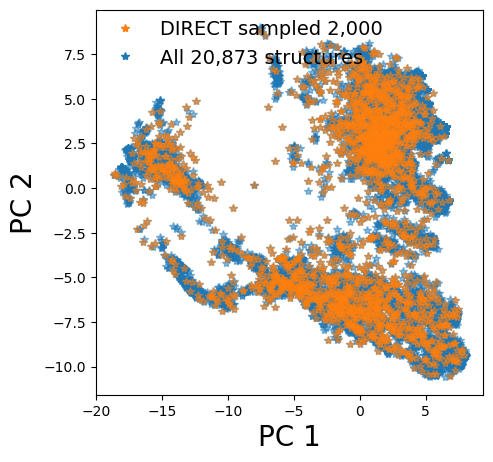

In [58]:
%%time
all_features = DIRECT_selection["PCAfeatures_unweighted"]
selected_indexes = DIRECT_selection["selected_indexes"]
plot_PCAfeature_coverage(all_features, selected_indexes)
#plt.ylim(-18, 32)

In [59]:
def calculate_feature_coverage_score(all_features, selected_indexes, n_bins=100):
    selected_features = all_features[selected_indexes]
    n_all = np.count_nonzero(
        np.histogram(all_features, bins=np.linspace(min(all_features), max(all_features), n_bins))[0]
    )
    n_select = np.count_nonzero(
        np.histogram(selected_features, bins=np.linspace(min(all_features), max(all_features), n_bins))[0]
    )
    return n_select / n_all

In [60]:
def calculate_all_FCS(all_features, selected_indexes, b_bins=100):
    select_scores = [
        calculate_feature_coverage_score(all_features[:, i], selected_indexes, n_bins=b_bins)
        for i in range(all_features.shape[1])
    ]
    return select_scores

In [61]:
import random
manual_selection_index = np.random.choice(range(len(all_features)), 2000, replace=False)

CPU times: user 7.96 ms, sys: 7.77 ms, total: 15.7 ms
Wall time: 14 ms


/tmp/ipykernel_28869/1745198056.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


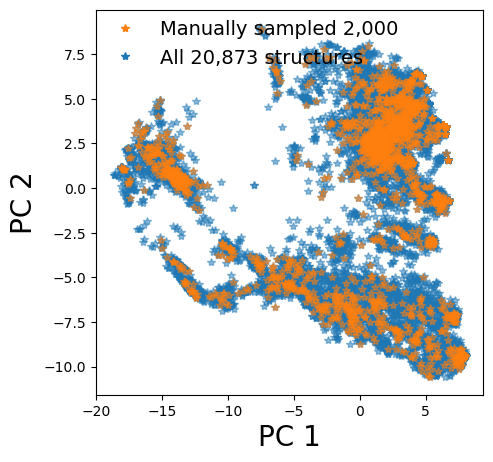

In [62]:
%%time
plot_PCAfeature_coverage(all_features, manual_selection_index, "Manually")

In [63]:
%%time
all_features = DIRECT_selection["PCAfeatures_unweighted"]
scores_DIRECT = calculate_all_FCS(all_features, DIRECT_selection["selected_indexes"], b_bins=50)
scores_MS = calculate_all_FCS(all_features, manual_selection_index, b_bins=100)

CPU times: user 191 ms, sys: 0 ns, total: 191 ms
Wall time: 189 ms


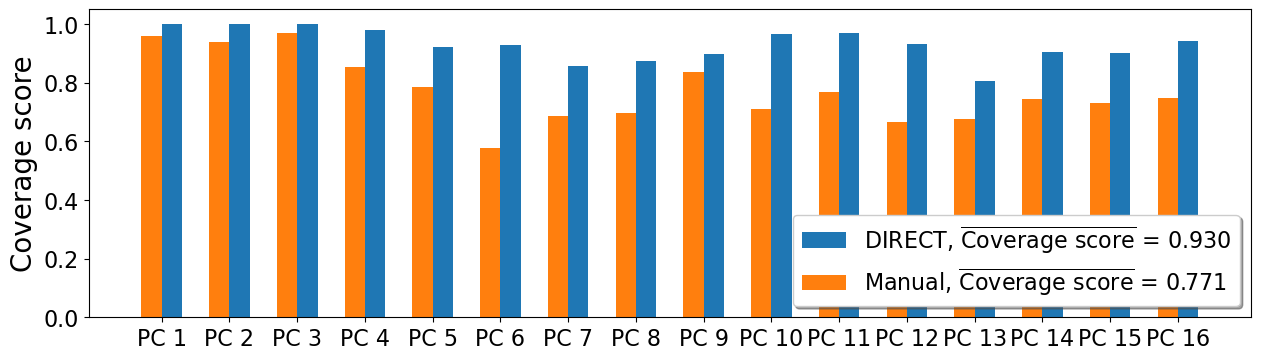

In [64]:
x = np.arange(len(scores_DIRECT))
x_ticks = [f"PC {n+1}" for n in range(len(x))]

plt.figure(figsize=(15, 4))
plt.bar(
    x + 0.6,
    scores_DIRECT,
    width=0.3,
    label=rf"DIRECT, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_DIRECT):.3f}",
)
plt.bar(
    x + 0.3,
    scores_MS,
    width=0.3,
    label=rf"Manual, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_MS):.3f}",
)
plt.xticks(x + 0.45, x_ticks, size=16)
plt.yticks(np.linspace(0, 1.0, 6), size=16)
plt.ylabel("Coverage score", size=20)
plt.legend(shadow=True, loc="lower right", fontsize=16)

In [69]:
# extract selected structures by direct
select_dict = {}
for ind in DIRECT_selection["selected_indexes"]:
    sys_name = sys_list[ind]
    name_split = sys_name.split('-')
    lbsys_sname = name_split[0]
    index_sys = int(name_split[1])
    select_dict[lbsys_sname] = select_dict.get(lbsys_sname, []) + [index_sys]

In [70]:
# get sampled dpdata
sample_data = dpdata.MultiSystems()
other_data = dpdata.MultiSystems()
for lbsys in alldata:
    sname = lbsys.short_name
    if sname in select_dict.keys():
        for ind,sys in enumerate(lbsys):
            if ind in select_dict[sname]:
                sample_data.append(sys)
            else:
                other_data.append(sys)
    else:
        other_data.append(lbsys)
print(sample_data)
print(other_data)

MultiSystems (494 systems containing 2000 frames)
MultiSystems (581 systems containing 18873 frames)


In [71]:
sample_data.to_deepmd_npy_mixed("./sampled-data-direct-10p")
other_data.to_deepmd_npy_mixed("./other-data-direct-10p")

MultiSystems (581 systems containing 18873 frames)